In [33]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openai
# openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_key = 'your api key'
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data

%load_ext autoreload
%autoreload 2

d:\software\python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [99]:

def plot_preds(train, test, pred_dict, model_name, mse, ds_name):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.title(ds_name + '_' + model_name)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    plt.legend(loc='upper left')
    mse_name = model_name + '_mse'
    plt.text(0.03, 0.85, f'{mse_name}: {mse:.2f} ', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [35]:
gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    # 'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    # 'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    # 'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    # 'PromptCast GPT-3.5':{'model': 'gpt-3.5-turbo-instruct', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {
    'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    # 'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())

In [100]:
from sklearn.metrics import mean_squared_error
def out(train, test, ds_name, model_hypers=model_hypers, model_names=model_names):
    out = {}
    for model in model_names: # GPT-4 takes a about a minute to run
        model_hypers[model].update({'dataset_name': ds_name}) # for promptcast
        hypers = list(grid_iter(model_hypers[model]))
        num_samples = 10
        pred_dict = get_autotuned_predictions_data(train, test, hypers, num_samples, model_predict_fns[model], verbose=False, parallel=False)
        out[model] = pred_dict
        
        pred = pred_dict['median']
        pred = pd.Series(pred, index=test.index)
        mse = mean_squared_error(test, pred)
        out[model+"_mse"] = mse
        plot_preds(train, test, pred_dict, model, mse, ds_name)
    return out

In [37]:
import random
def result(ds_name):
    print('before data length:',len(data))
    if len(data) > 500:   
        random_number = random.randint(0, len(data)-500)
        data = data[random_number:random_number+500]
    print('after data length:',len(data))
    testfrac = 0.2
    splitpoint = int(len(data)*(1-testfrac))
    train = data.iloc[:splitpoint]
    test = data.iloc[splitpoint:]
    print('test length:', len(test))
    res = out(train, test, ds_name)
    print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
    print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

In [101]:
mse_result = dict()

# Export_China_Monthly









100%|██████████| 1/1 [00:09<00:00,  9.41s/it]


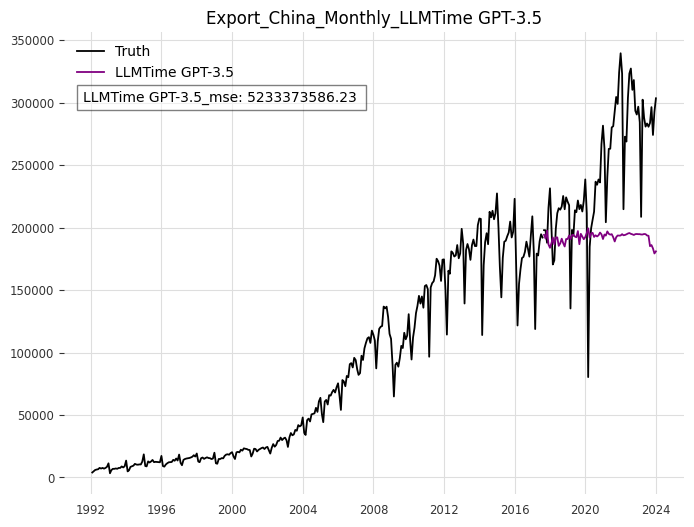

Train length: 230, Val length: 77






d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




d:\software\python\lib\site-packages\statsmodels\tsa\statespace\

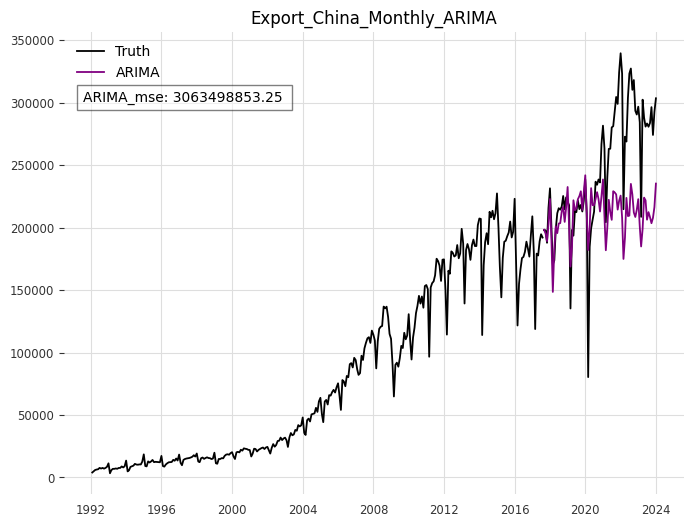

Export_China_Monthly_LLMTime GPT-3.5_mse: 5233373586.22943
Export_China_Monthly_ARIMA_mse: 3063498853.246838


In [139]:
ds_name = 'Export_China_Monthly'
folder_path = 'D:/edge_download/llmtime-main/datasets/economy/Export_China_Monthly.csv'
dataframe = pd.read_csv(folder_path)
dataframe = dataframe[28:]
data = []
for i in list(dataframe.iloc[:,1]):
    data.append(float(i))

index = pd.date_range(start=dataframe.iloc[0,0], periods=len(data), freq='M')
series = pd.Series(data, index=index)

testfrac=0.2
splitpoint = int(len(series)*(1-testfrac))
train = series[:splitpoint]
test = series[splitpoint:]
res = out(train, test, ds_name)

mse_result[ds_name] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# Export_HongKong_Monthly

before data length: 805
after data length: 500














100%|██████████| 1/1 [00:13<00:00, 13.13s/it]


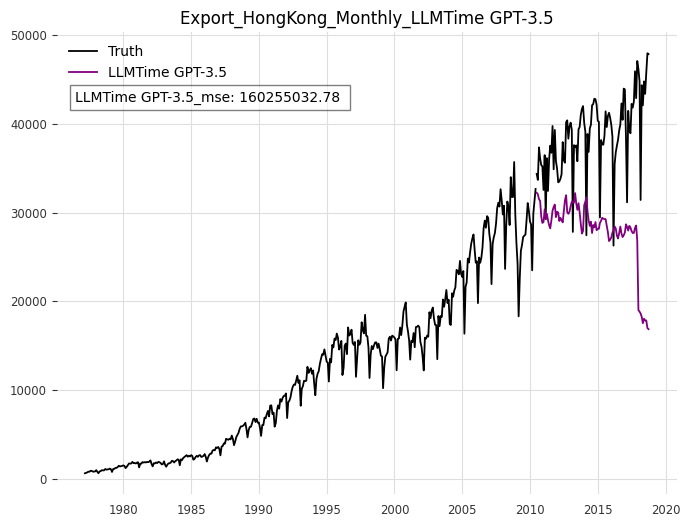

Train length: 300, Val length: 100








d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "






d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "






d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationar

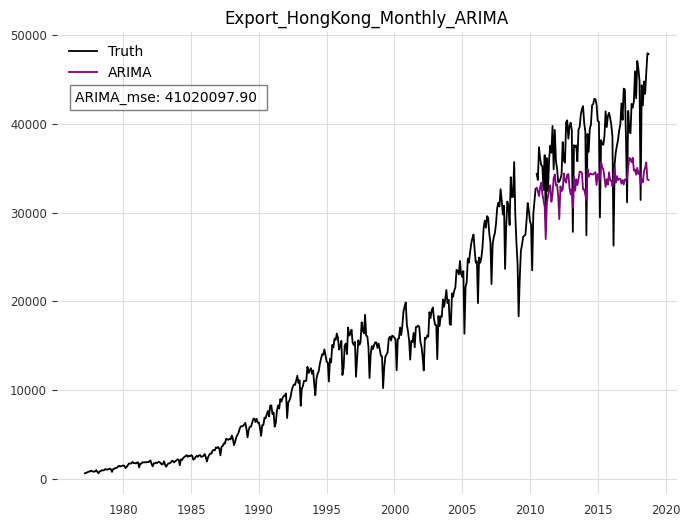

Export_HongKong_Monthly_LLMTime GPT-3.5_mse: 160255032.78219908
Export_HongKong_Monthly_ARIMA_mse: 41020097.89950325


In [154]:
ds_name = 'Export_HongKong_Monthly'
folder_path = 'D:/edge_download/llmtime-main/datasets/economy/Export_HongKong_Monthly.csv'
dataframe = pd.read_csv(folder_path)
dataframe = dataframe[28:]
data = []
for i in list(dataframe.iloc[:,1]):
    data.append(float(i))

index = pd.date_range(start=dataframe.iloc[0,0], periods=len(data), freq='M')
series = pd.Series(data, index=index)

print('before data length:',len(series))
if len(series) > 500:   
    random_number = random.randint(0, len(series)-500)
    series = series[random_number:random_number+500]
print('after data length:',len(series))

testfrac=0.2
splitpoint = int(len(series)*(1-testfrac))
train = series[:splitpoint]
test = series[splitpoint:]
res = out(train, test, ds_name)

mse_result[ds_name] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# Export_France_Monthly









100%|██████████| 1/1 [00:07<00:00,  7.92s/it]


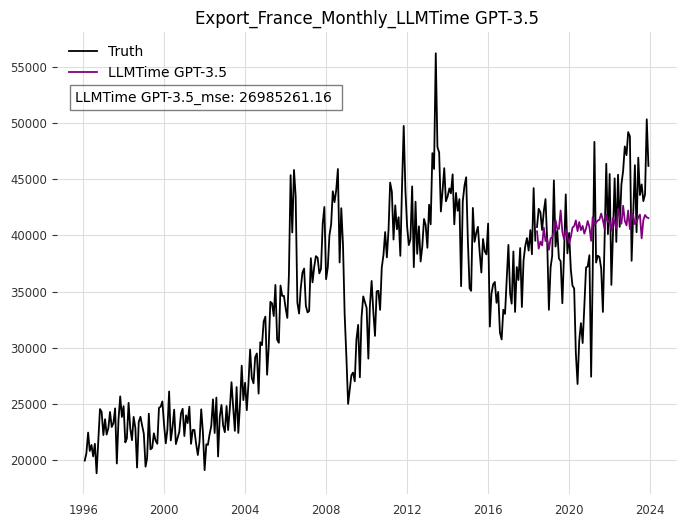

Train length: 201, Val length: 67






d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "








d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "




d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood o

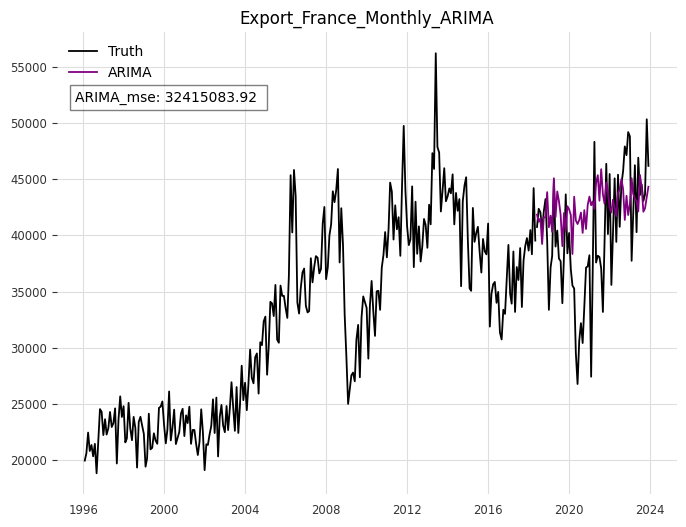

Export_France_Monthly_LLMTime GPT-3.5_mse: 26985261.164193813
Export_France_Monthly_ARIMA_mse: 32415083.91921227


In [141]:
ds_name = 'Export_France_Monthly'
folder_path = 'D:/edge_download/llmtime-main/datasets/economy/Export_France_Monthly.csv'
dataframe = pd.read_csv(folder_path)
dataframe = dataframe[28:]
data = []
for i in list(dataframe.iloc[:,1]):
    data.append(float(i))

index = pd.date_range(start=dataframe.iloc[0,0], periods=len(data), freq='M')
series = pd.Series(data, index=index)

testfrac=0.2
splitpoint = int(len(series)*(1-testfrac))
train = series[:splitpoint]
test = series[splitpoint:]
res = out(train, test, ds_name)

mse_result[ds_name] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# Export_UK_Monthly











100%|██████████| 1/1 [00:10<00:00, 10.69s/it]


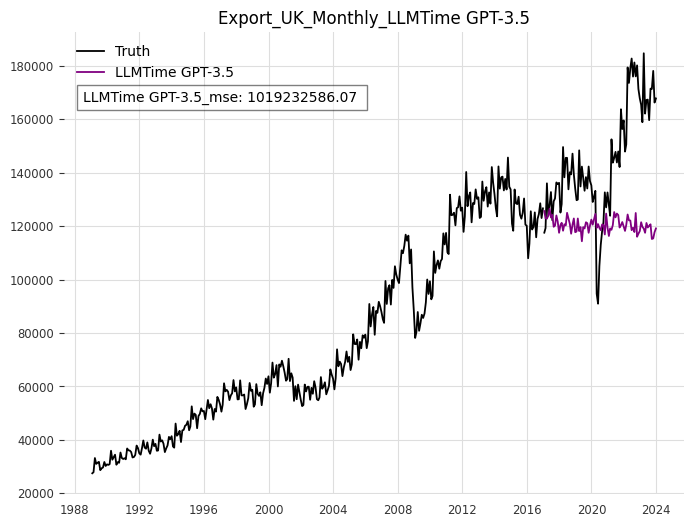

Train length: 252, Val length: 84







d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "





d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "





d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary s

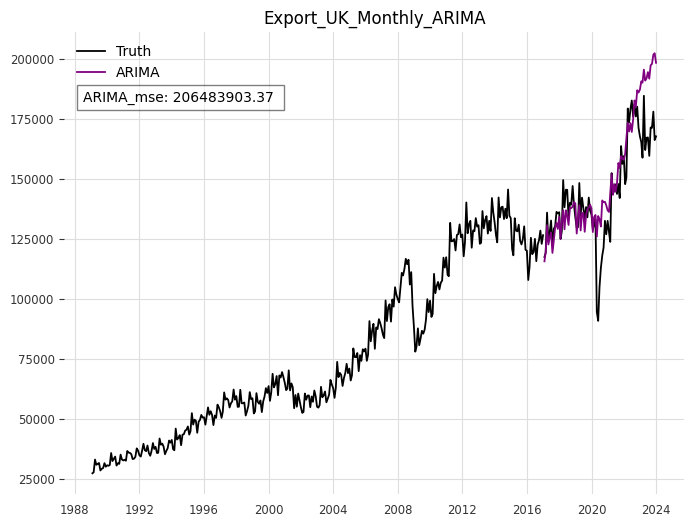

Export_UK_Monthly_LLMTime GPT-3.5_mse: 1019232586.0705602
Export_UK_Monthly_ARIMA_mse: 206483903.36513114


In [143]:
ds_name = 'Export_UK_Monthly'
folder_path = 'D:/edge_download/llmtime-main/datasets/economy/Export_UK_Monthly.csv'
dataframe = pd.read_csv(folder_path)
dataframe = dataframe[28:]
data = []
for i in list(dataframe.iloc[:,1]):
    data.append(float(i))

index = pd.date_range(start=dataframe.iloc[0,0], periods=len(data), freq='M')
series = pd.Series(data, index=index)

testfrac=0.2
splitpoint = int(len(series)*(1-testfrac))
train = series[:splitpoint]
test = series[splitpoint:]
res = out(train, test, ds_name)

mse_result[ds_name] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# Export_American_Monthly

before data length: 805
after data length: 500














100%|██████████| 1/1 [00:12<00:00, 12.81s/it]


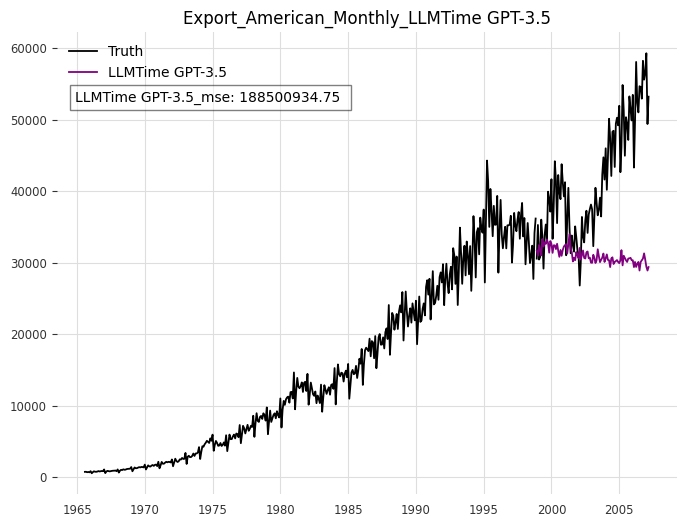

Train length: 300, Val length: 100








d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "






d:\software\python\lib\site-packages\statsmodels\tsa\statesp

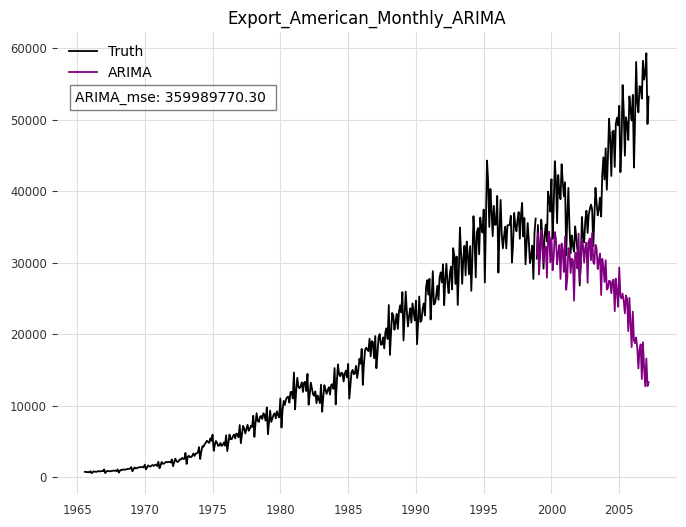

Export_American_Monthly_LLMTime GPT-3.5_mse: 188500934.75284275
Export_American_Monthly_ARIMA_mse: 359989770.2960958


In [145]:
ds_name = 'Export_American_Monthly'
folder_path = 'D:/edge_download/llmtime-main/datasets/economy/Export_American_Monthly.csv'
dataframe = pd.read_csv(folder_path)
dataframe = dataframe[28:]
data = []
for i in list(dataframe.iloc[:,1]):
    data.append(float(i))

index = pd.date_range(start=dataframe.iloc[0,0], periods=len(data), freq='M')
series = pd.Series(data, index=index)

print('before data length:',len(series))
if len(series) > 500:   
    random_number = random.randint(0, len(series)-500)
    series = series[random_number:random_number+500]
print('after data length:',len(series))

testfrac=0.2
splitpoint = int(len(series)*(1-testfrac))
train = series[:splitpoint]
test = series[splitpoint:]
res = out(train, test, ds_name)

mse_result[ds_name] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])

# Export_Japan_Monthly

before data length: 288
after data length: 288














100%|██████████| 1/1 [00:07<00:00,  7.02s/it]


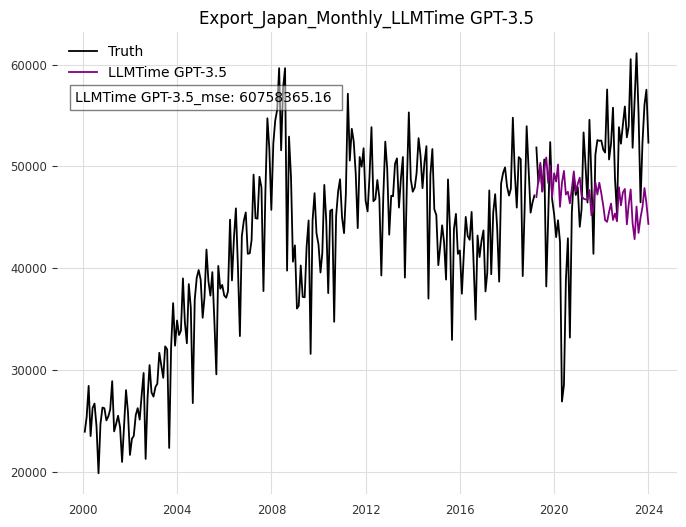

Train length: 172, Val length: 58








d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "






d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\software\python\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "






d:\software\python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationar

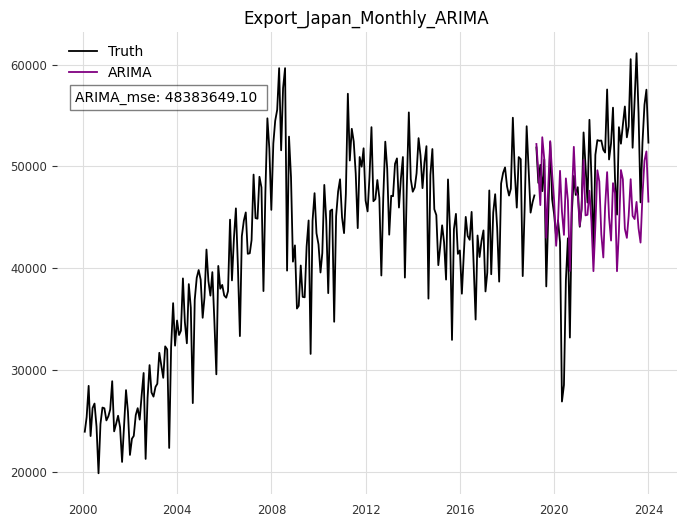

Export_Japan_Monthly_LLMTime GPT-3.5_mse: 60758365.160605684
Export_Japan_Monthly_ARIMA_mse: 48383649.10279014


In [146]:
ds_name = 'Export_Japan_Monthly'
folder_path = 'D:/edge_download/llmtime-main/datasets/economy/Export_Japan_Monthly.csv'
dataframe = pd.read_csv(folder_path)
dataframe = dataframe[28:]
data = []
for i in list(dataframe.iloc[:,1]):
    data.append(float(i))

index = pd.date_range(start=dataframe.iloc[0,0], periods=len(data), freq='M')
series = pd.Series(data, index=index)

print('before data length:',len(series))
if len(series) > 500:   
    random_number = random.randint(0, len(series)-500)
    series = series[random_number:random_number+500]
print('after data length:',len(series))

testfrac=0.2
splitpoint = int(len(series)*(1-testfrac))
train = series[:splitpoint]
test = series[splitpoint:]
res = out(train, test, ds_name)

mse_result[ds_name] = {'LLMTime GPT-3.5_mse' :res['LLMTime GPT-3.5_mse'], 'ARIMA_mse': res['ARIMA_mse']}
print(ds_name + '_LLMTime GPT-3.5_mse:', res['LLMTime GPT-3.5_mse'])
print(ds_name + '_ARIMA_mse:', res['ARIMA_mse'])